# Predicting Simulation Crashes

This notebook will attempt to classify climate model simulations as failures or successes, whether or not they crash, from their input parammeters.

<blockquote>
    Attribute Information<br />
    Column 1: Latin hypercube study ID (study 1 to study 3)<br />
    Column 2: simulation ID (run 1 to run 180)<br />
    Columns 3-20: values of 18 climate model parameters scaled in the interval [0, 1]<br />
    Column 21: simulation outcome (0 = failure, 1 = success)<br />
    <br />
    Further details about the data and methods are given in the publication 'Failure Analysis of Parameter-Induced Simulation Crashes in Climate Models,' Geoscientific Model Development (doi:10.5194/gmdd-6-585-2013).
</blockquote>

**Data Source:**
Lucas,D., Klein,R., Tannahill,J., Ivanova,D., Brandon,S., Domyancic,D., Zhang,Y., D.,D. & D.
,D.. (2013). Climate Model Simulation Crahes. UCI Machine Learning Repository. https://doi.org/10.24432/C5HG71.


## Outline
1. [Data Validation](#data_validation)
2. [Exploratory Analysis](#exploratory_analysis)
3. [Model Development](#model_development)
4. [Model Evaluation](#model_evaluation)

<a id='data_validation'></a>
## 1. Data Validation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

Load data

In [2]:
sims = pd.read_csv('./data/pop_failures.dat', sep='\s+')

Check validate column data types

In [3]:
sims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Study                 540 non-null    int64  
 1   Run                   540 non-null    int64  
 2   vconst_corr           540 non-null    float64
 3   vconst_2              540 non-null    float64
 4   vconst_3              540 non-null    float64
 5   vconst_4              540 non-null    float64
 6   vconst_5              540 non-null    float64
 7   vconst_7              540 non-null    float64
 8   ah_corr               540 non-null    float64
 9   ah_bolus              540 non-null    float64
 10  slm_corr              540 non-null    float64
 11  efficiency_factor     540 non-null    float64
 12  tidal_mix_max         540 non-null    float64
 13  vertical_decay_scale  540 non-null    float64
 14  convect_corr          540 non-null    float64
 15  bckgrnd_vdc1          5

Validate data ranges

In [4]:
# Study column should only have 1, 2, and 3
sims['Study'].value_counts()

Study
1    180
2    180
3    180
Name: count, dtype: int64

In [5]:
# Run should have values 1 - 180, each with a count of 3
run_counts = sims['Run'].value_counts()
values_bool = run_counts.index.isin(range(1, 181)).all()
counts_bool = (run_counts.values == 3).all()
print(f'Run ids are valid: {values_bool and counts_bool}')
del run_counts, values_bool, counts_bool

Run ids are valid: True


In [6]:
# Values of columns 3 - 20 (2 - 19 when 0-indexed) should be in [0,1]
for ind in range(2, 20):
    col_bool = bool(sims.iloc[:, ind].between(0, 1).all()) # avoid numpy.bool warning
    print(f'Column {ind}: ' + 'valid'*col_bool + 'problem'*(not col_bool))

Column 2: valid
Column 3: valid
Column 4: valid
Column 5: valid
Column 6: valid
Column 7: valid
Column 8: valid
Column 9: valid
Column 10: valid
Column 11: valid
Column 12: valid
Column 13: valid
Column 14: valid
Column 15: valid
Column 16: valid
Column 17: valid
Column 18: valid
Column 19: valid


In [7]:
# Outcome should be 0 or 1
sims['outcome'].value_counts()

outcome
1    494
0     46
Name: count, dtype: int64

The target column is valid, but highly imbalanced. This will be handled later on with upscaling.

<a id='exploratory_analysis'></a>
## 2. Exploratory Analysis

Make a copy of the `sims` dataframe to keep original and make development related edits to the new dataframe. Immediately, we know the simulation id (Run), has no effect on the outcome, so drop it.

In [8]:
X = sims.copy().drop('Run', axis=1) # will seperate 'outcome' into y after analysis

Plot distributions of each feature, distinguishing between outcome classes.

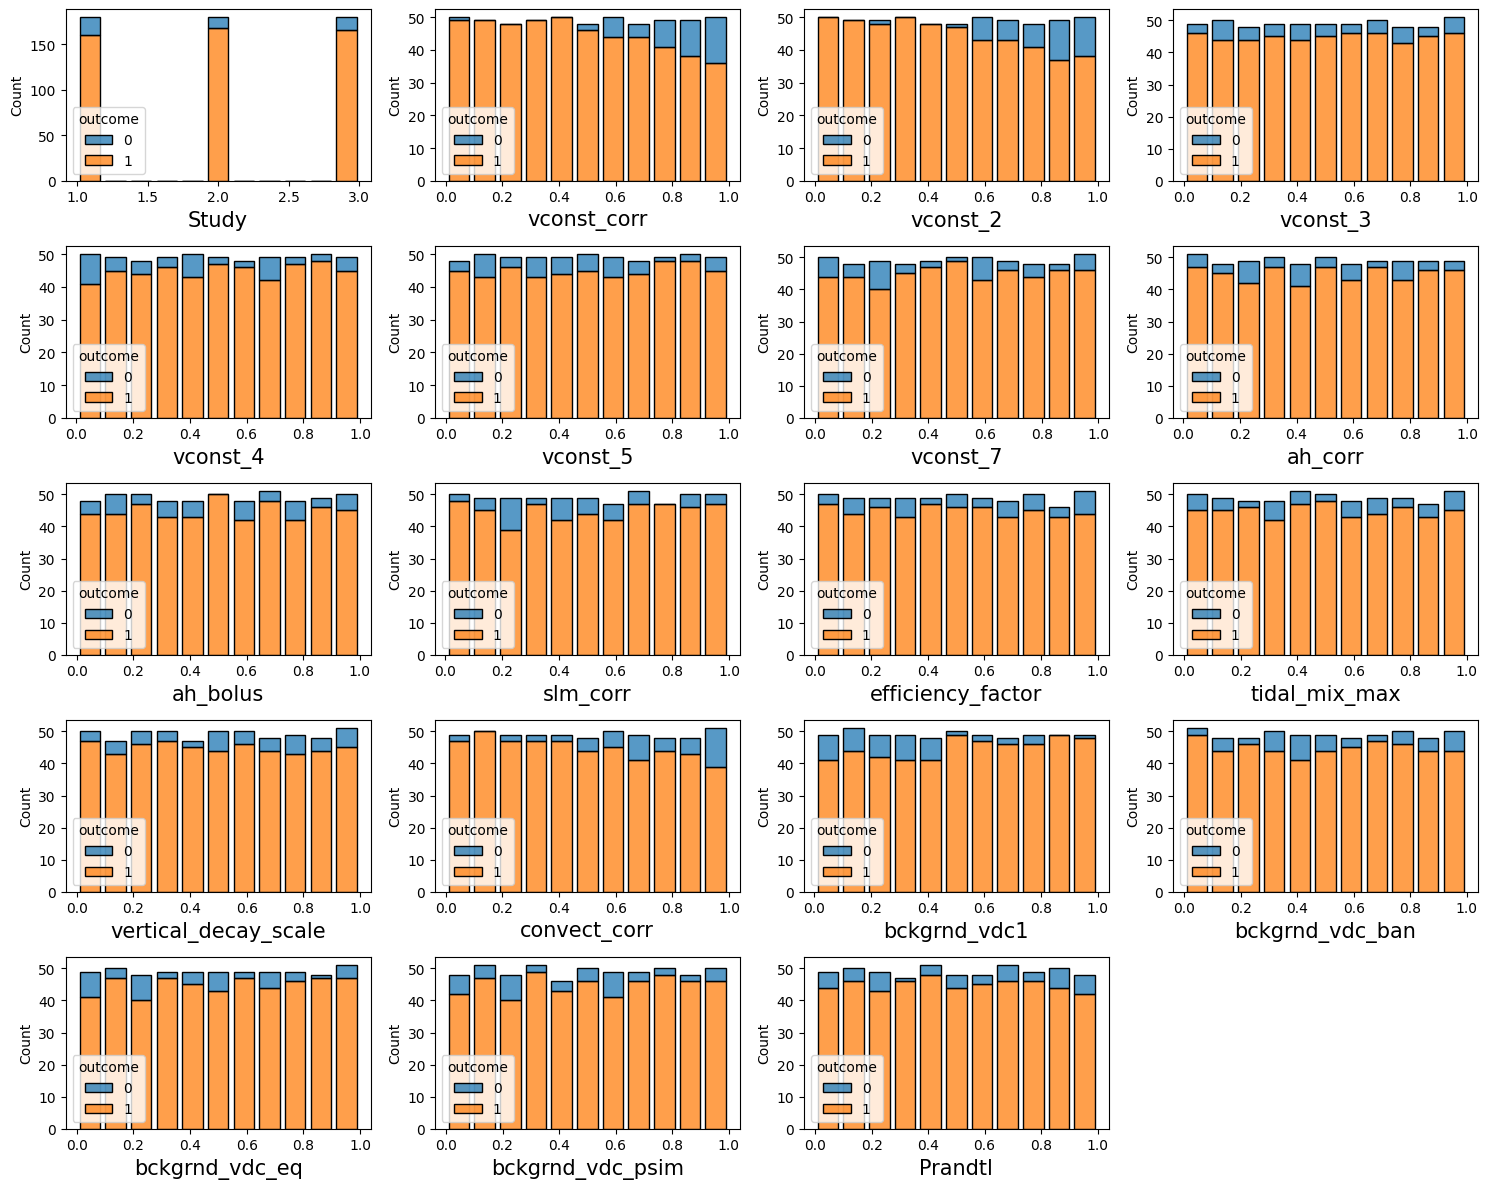

In [9]:
fig, axs = plt.subplots(5, 4, figsize=(15, 12))

for ind, ax in enumerate(axs.flatten()):
    
    # Clear last, only have 19 features
    if ind == 19:
        ax.axis('off')
        continue
        
    # Stacked histograms
    feat = X.columns[ind]
    sns.histplot(X, x=feat, hue='outcome', multiple='stack', shrink=0.8, ax=ax)
    ax.set_xlabel(ax.get_xlabel(), fontsize=15)

# Make space for xlabels
plt.tight_layout()

Quantify with Pearson correlations

In [10]:
X.corr()['outcome'][X.columns != 'outcome']

Study                   0.048748
vconst_corr            -0.304787
vconst_2               -0.302388
vconst_3                0.000227
vconst_4                0.072297
vconst_5                0.054390
vconst_7                0.048646
ah_corr                 0.017049
ah_bolus                0.003895
slm_corr                0.048864
efficiency_factor      -0.032364
tidal_mix_max          -0.015071
vertical_decay_scale   -0.045862
convect_corr           -0.192893
bckgrnd_vdc1            0.184218
bckgrnd_vdc_ban        -0.028365
bckgrnd_vdc_eq          0.078504
bckgrnd_vdc_psim        0.057684
Prandtl                -0.026942
Name: outcome, dtype: float64

The features that are most correlated to a failed outcome are:
1. vconst_corr (high)
2. vconst_2 (high)
3. convect_corr (high)
4. bckgrnd_vdc1 (low)

The Pearson correlations are small, but this is affected by the class imbalance. The trends are clear in the distributions.

<a id='model_development'></a>
## 3. Model Development

<a id='model_evaluation'></a>
## 4. Model Evaluation